In [2]:
!pip install xgboost
!pip install plotnine

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import pickle
import glob
import os
import sys
import pandas as pd
import plotnine
from plotnine import *

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

from model_dataset.src.main import load_dataframe

## Outcome Analysis

In [4]:
settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "OP-21.csv",
    "FULL_MEASURE_S3_PREFIX": "OP-21",
    "filter_measure": "OP_21", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "model_pickle_path": "models",
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

### Load XGBoost Regression Model

In [5]:
models_prepath = f"{settings.get('model_pickle_path')}/xgboost_regression/"
list_of_model_info = glob.glob(f"{models_prepath}/*.p")
latest_model_info = max(list_of_model_info, key=os.path.getctime)
print("Using model info: ", latest_model_info)

with open(latest_model_info, 'rb') as handle:
    xgbr_model_info = pickle.load(handle)

Using model info:  models/xgboost_regression/model_info_2022-12-21-20h20m.p


### Load Isolation Forest

In [6]:
models_prepath = f"{settings.get('model_pickle_path')}/isolation_forest/"
list_of_model_info = glob.glob(f"{models_prepath}/*.p")
latest_model_info = max(list_of_model_info, key=os.path.getctime)
print("Using model info: ", latest_model_info)

with open(latest_model_info, 'rb') as handle:
    if_model_info = pickle.load(handle)

Using model info:  models/isolation_forest/model_info_2022-12-21-20h23m.p


### Load Ensemble Model

In [7]:
models_prepath = f"{settings.get('model_pickle_path')}/ensemble_model/"
list_of_model_info = glob.glob(f"{models_prepath}/*.p")
latest_model_info = max(list_of_model_info, key=os.path.getctime)
print("Using model info: ", latest_model_info)

with open(latest_model_info, 'rb') as handle:
    ensemble_model_info = pickle.load(handle)

Using model info:  models/ensemble_model/model_info_2022-12-20-01h06m.p


In [8]:
outcome_analysis_settings = {
    "if_model": if_model_info.get('model'),
    "if_threshold": if_model_info.get('threshold'),

    "xgbr_model": xgbr_model_info.get('model'),
    "xgbr_threshold": xgbr_model_info.get('threshold'),
    
    "ensemble_model": ensemble_model_info.get('model'),
    "ensemble_threshold": ensemble_model_info.get('threshold'),
}

settings = {**settings, **outcome_analysis_settings}
# outcome_analysis_settings

### Prepare Comparison

In [9]:
modeling_dataset = load_dataframe(settings.get('model_dataset_path'), []).dropna(subset = ['lag1'])
modeling_dataset['y_quarter'] = modeling_dataset['year'].astype(str) + 'Q' + modeling_dataset['quarter'].astype(str)
modeling_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,80.0,84.0,NaN,2014,2,-4.0,84.000000,-4.000000,2014Q2
2,100001,75.0,80.0,84.0,2014,3,-5.0,82.000000,-7.000000,2014Q3
3,100001,73.0,75.0,80.0,2015,1,-2.0,79.666667,-6.666667,2015Q1
4,100001,69.0,73.0,75.0,2015,2,-4.0,78.000000,-9.000000,2015Q2
5,100001,71.0,69.0,73.0,2015,3,2.0,76.200000,-5.200000,2015Q3
...,...,...,...,...,...,...,...,...,...,...
50653,90011,56.0,89.0,101.0,2017,1,-33.0,85.100000,-29.100000,2017Q1
50654,90011,41.0,56.0,89.0,2017,2,-15.0,82.454545,-41.454545,2017Q2
50655,90011,40.0,41.0,56.0,2017,3,-1.0,79.000000,-39.000000,2017Q3
50656,90011,36.0,40.0,41.0,2017,4,-4.0,76.000000,-40.000000,2017Q4


#### XGBoost Regression

In [10]:
xgbr_model = settings.get("xgbr_model")
xgbr_selected_features = xgbr_model_info.get('selected_features')
xgbr_scores = xgbr_model.predict(modeling_dataset[xgbr_selected_features])
xgbr_prediction = abs(modeling_dataset['score'] - xgbr_scores) > settings.get('xgbr_threshold')

xgbr_dataset = modeling_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgbr_dataset['outlier'] = xgbr_prediction
xgbr_dataset['model_score'] = xgbr_scores
xgbr_dataset['model'] = "XGBoost Regression"
xgbr_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,80.0,2014Q2,100001,84.000000,-4.0,-4.000000,False,81.595543,XGBoost Regression
2,75.0,2014Q3,100001,82.000000,-5.0,-7.000000,False,77.804817,XGBoost Regression
3,73.0,2015Q1,100001,79.666667,-2.0,-6.666667,False,73.048630,XGBoost Regression
4,69.0,2015Q2,100001,78.000000,-4.0,-9.000000,False,71.574181,XGBoost Regression
5,71.0,2015Q3,100001,76.200000,2.0,-5.200000,False,67.277702,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
50653,56.0,2017Q1,90011,85.100000,-33.0,-29.100000,True,85.878624,XGBoost Regression
50654,41.0,2017Q2,90011,82.454545,-15.0,-41.454545,True,54.221302,XGBoost Regression
50655,40.0,2017Q3,90011,79.000000,-1.0,-39.000000,False,39.075642,XGBoost Regression
50656,36.0,2017Q4,90011,76.000000,-4.0,-40.000000,False,37.782131,XGBoost Regression


#### Isolation Forest

In [11]:
if_model = settings.get("if_model")
if_drop_cols = if_model_info.get("drop_cols")
if_scores = if_model.score_samples(modeling_dataset.drop(columns=[*if_drop_cols, 'y_quarter'])) * -1
if_prediction = if_scores > settings.get('if_threshold')

if_dataset = modeling_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_dataset['outlier'] = if_prediction
if_dataset['model_score'] = if_scores
if_dataset['model'] = "Isolation Forest"
if_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,80.0,2014Q2,100001,84.000000,-4.0,-4.000000,False,0.473703,Isolation Forest
2,75.0,2014Q3,100001,82.000000,-5.0,-7.000000,False,0.472472,Isolation Forest
3,73.0,2015Q1,100001,79.666667,-2.0,-6.666667,False,0.453241,Isolation Forest
4,69.0,2015Q2,100001,78.000000,-4.0,-9.000000,False,0.456307,Isolation Forest
5,71.0,2015Q3,100001,76.200000,2.0,-5.200000,False,0.444458,Isolation Forest
...,...,...,...,...,...,...,...,...,...
50653,56.0,2017Q1,90011,85.100000,-33.0,-29.100000,True,0.644544,Isolation Forest
50654,41.0,2017Q2,90011,82.454545,-15.0,-41.454545,True,0.599706,Isolation Forest
50655,40.0,2017Q3,90011,79.000000,-1.0,-39.000000,True,0.518135,Isolation Forest
50656,36.0,2017Q4,90011,76.000000,-4.0,-40.000000,True,0.525300,Isolation Forest


#### Ensemble Model

In [12]:
ensemble_model = settings.get("ensemble_model")
ensemble_selected_features = ensemble_model_info.get('selected_features')
ensemble_dataset = modeling_dataset.copy()[['lag1','prov_mean','score']]
ensemble_dataset['iforest_score'] = if_scores

ensemble_scores = ensemble_model.predict(ensemble_dataset[ensemble_selected_features])
ensemble_prediction = abs(ensemble_dataset['score'] - ensemble_scores) > settings.get('ensemble_threshold')

ensemble_dataset = modeling_dataset.copy()[['score', 'y_quarter', 'provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_dataset['outlier'] = ensemble_prediction
ensemble_dataset['model_score'] = ensemble_scores
ensemble_dataset['model'] = "Ensemble Model"

In [13]:
(ensemble_dataset['score'] - ensemble_dataset['model_score'])\
    .describe(percentiles = [.01, .1, .25, .5, .75, .9, .99])

count    46832.000000
mean         0.310331
std          5.528448
min        -71.848373
1%         -16.123065
10%         -5.532322
25%         -2.244579
50%          0.240898
75%          3.061474
90%          6.631930
99%         13.846032
max         99.116257
dtype: float64

#### Combined

In [14]:
comparison_df = pd.concat([xgbr_dataset, if_dataset, ensemble_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,80.0,2014Q2,100001,84.000000,-4.0,-4.000000,False,81.595543,XGBoost Regression
2,75.0,2014Q3,100001,82.000000,-5.0,-7.000000,False,77.804817,XGBoost Regression
3,73.0,2015Q1,100001,79.666667,-2.0,-6.666667,False,73.048630,XGBoost Regression
4,69.0,2015Q2,100001,78.000000,-4.0,-9.000000,False,71.574181,XGBoost Regression
5,71.0,2015Q3,100001,76.200000,2.0,-5.200000,False,67.277702,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
50653,56.0,2017Q1,90011,85.100000,-33.0,-29.100000,True,82.084846,Ensemble Model
50654,41.0,2017Q2,90011,82.454545,-15.0,-41.454545,False,49.636002,Ensemble Model
50655,40.0,2017Q3,90011,79.000000,-1.0,-39.000000,False,40.042366,Ensemble Model
50656,36.0,2017Q4,90011,76.000000,-4.0,-40.000000,False,37.884331,Ensemble Model


### CV RMSE and AUROC

#### XGBoost Regression

In [15]:
xgbr_model_info.get('cv_rmse')

6.3130329099638445

#### Ensemble Model

In [16]:
ensemble_model_info.get('cv_rmse')

6.10635431355035

||XGBoost Regression|Isolation Forest|XGBoost Ensemble|
|---|---|---|---|
|CV RMSE| 6.31 | N/A | 6.11
|AUROC|0.83|0.82|0.84|

### Predicted Outlier

In [17]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  41886.0          42020.0        42583.0   
      mean                      51.2             50.9           51.4   
      std                       16.5             14.3           16.7   
      min                       11.0             21.0           11.0   
      10%                       31.0             32.0           31.0   
      25%                       40.0             40.0           40.0   
      50%                       50.0             50.0           50.0   
      75%                       61.0             61.0           62.0   
      90%                       72.0             70.0           72.0   
      max                      156.0             91.0          160.0   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   4946.0           4812.0         4249.0  
      mean                      63.5             66.5           63.4  
      std                       22.5             32.2           22.4  
      min                        5.0              5.0            5.0  
      10%                       37.0             21.0           37.0  
      25%                       47.0             36.0           47.0  
      50%                       62.0             73.0           61.0  
      75%                       76.0             92.0           77.0  
      90%                       92.0            103.0           92.0  
      max                      262.0            262.0          262.0

### Outlier Counts by Quarter

#### XGBoost Regression Outlier Counts by Quarter

In [18]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,346,3137,11.03
2014Q3,339,3146,10.78
2015Q1,585,3137,18.65
2015Q2,353,3170,11.14
2015Q3,346,3145,11.00
2015Q4,295,3218,9.17
2016Q1,562,3308,16.99
2016Q3,573,3371,17.00
2016Q4,226,3496,6.46
2017Q1,248,3511,7.06


#### Isolation Forest Outlier Counts by Quarter

In [19]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,268,3137,8.54
2014Q3,262,3146,8.33
2015Q1,401,3137,12.78
2015Q2,348,3170,10.98
2015Q3,335,3145,10.65
2015Q4,308,3218,9.57
2016Q1,461,3308,13.94
2016Q3,479,3371,14.21
2016Q4,338,3496,9.67
2017Q1,334,3511,9.51


#### Ensemble Model Outlier Counts by Quarter

In [20]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2014Q2,311,3137,9.91
2014Q3,301,3146,9.57
2015Q1,513,3137,16.35
2015Q2,294,3170,9.27
2015Q3,285,3145,9.06
2015Q4,258,3218,8.02
2016Q1,466,3308,14.09
2016Q3,502,3371,14.89
2016Q4,185,3496,5.29
2017Q1,221,3511,6.29


In [21]:
outlier_comparison = comparison_df.query('model == "Ensemble Model"')[['outlier', 'lag_diff', 'prov_mean_diff']].copy()
outlier_comparison[['lag_diff', 'prov_mean_diff']] = abs(outlier_comparison[['lag_diff', 'prov_mean_diff']])
outlier_comparison = outlier_comparison.rename(columns = {'lag_diff':'Difference from Previous Score',
                                                          'prov_mean_diff': 'Difference from Provider Mean Score',
                                                          'outlier': 'Predicted Anomaly'})
outlier_comparison.groupby('Predicted Anomaly').describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).loc[:,(slice(None),['mean','std','1%', '10%', '25%', '50%', '75%','90%','99%'])].transpose()


Predicted Anomaly                             False       True
Difference from Previous Score      mean   3.057065  14.088021
                                    std    3.017115   7.396860
                                    1%     0.000000   6.000000
                                    10%    0.000000   9.000000
                                    25%    1.000000  10.000000
                                    50%    2.000000  12.000000
                                    75%    4.000000  16.000000
                                    90%    7.000000  21.000000
                                    99%   12.000000  42.000000
Difference from Provider Mean Score mean   6.465773  13.504581
                                    std    6.231438   9.611667
                                    1%     0.000000   0.333333
                                    10%    0.800000   3.776068
                                    25%    2.000000   7.500000
                                    50%    4.785714  12.000000
                                    75%    8.875000  17.666667
                                    90%   14.153846  24.000000
                                    99%   29.000000  43.760000

### Distribution of normal values vs predicted outlier values

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 16 rows containing non-finite values.


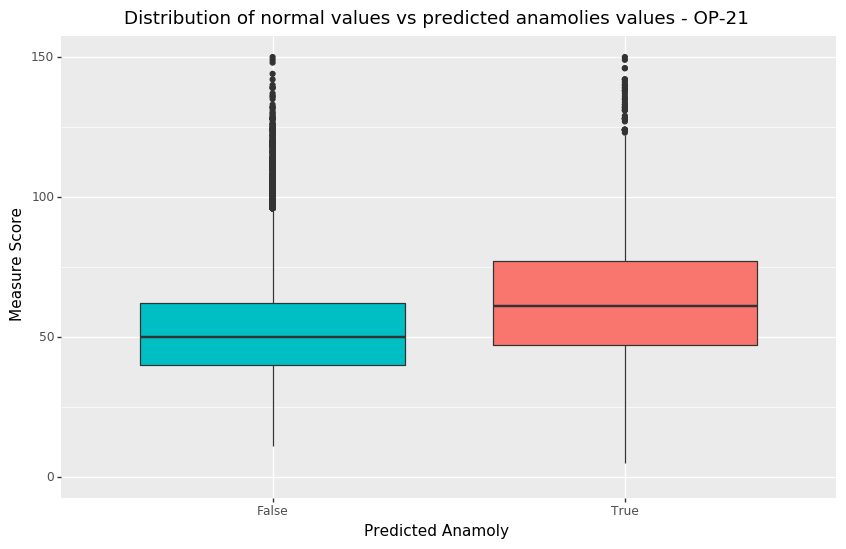

<ggplot: (8749048716997)>

In [33]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamolies values - OP-21")
 + ylab("Measure Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + ylim(0,150)
)

### Difference in current provider score compared to previous provider score

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 16 rows containing missing values.


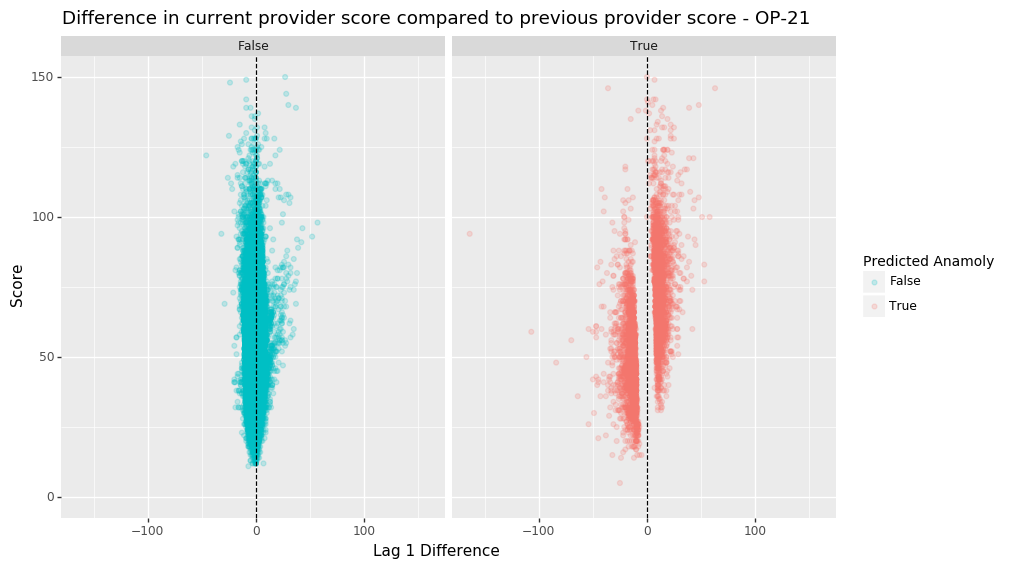

<ggplot: (8749121240053)>

In [23]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-21")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + ylim(0,150)
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


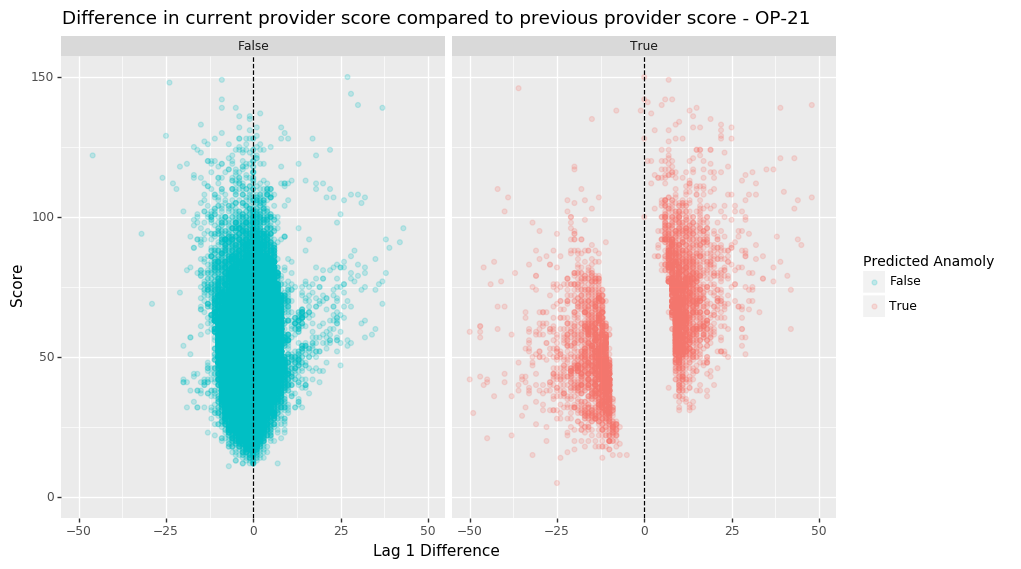

<ggplot: (8749048575257)>

In [36]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-21")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + ylim(0,150)
 + xlim(-50,50)
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 77 rows containing missing values.


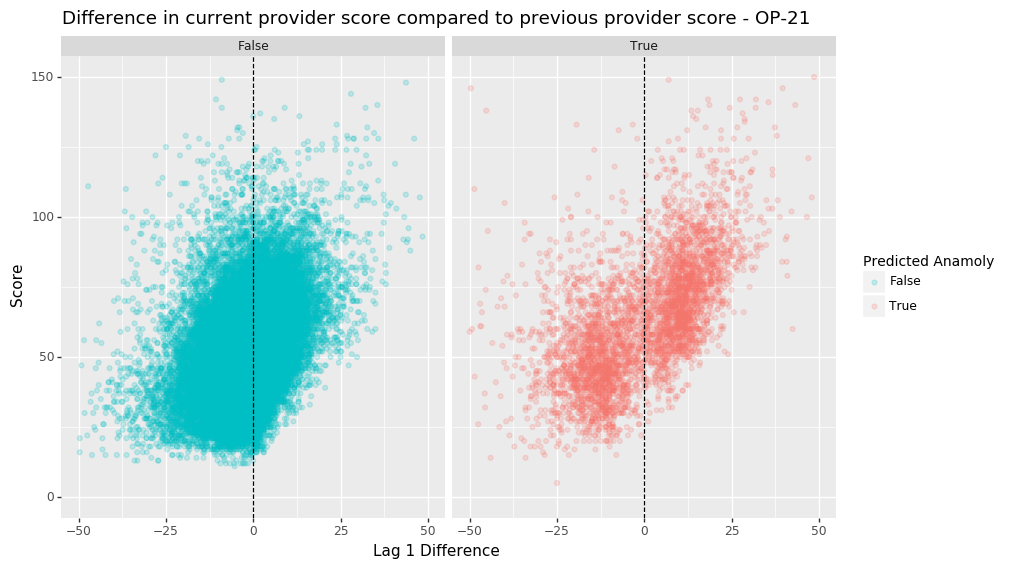

<ggplot: (8749106289225)>

In [34]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'prov_mean_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-21")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + ylim(0,150)
 + xlim(-50,50)
 + theme(legend_title = element_text(size = 10))
)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 68 rows containing missing values.


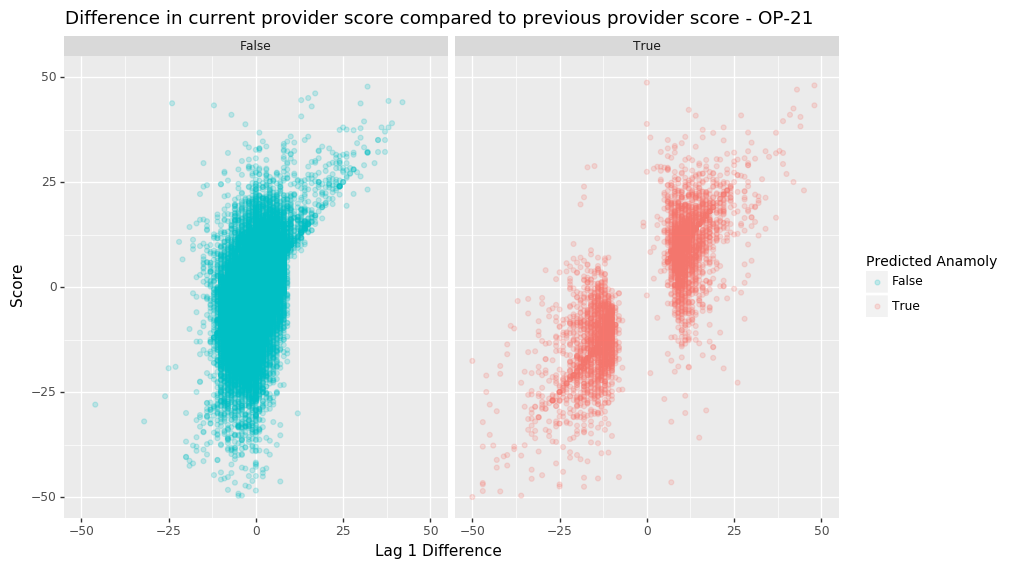

<ggplot: (8749048715617)>

In [35]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'prov_mean_diff',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - OP-21")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 #+ geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + ylim(-50,50)
 + xlim(-50,50)
 + theme(legend_title = element_text(size = 10))
)

In [27]:
comparison_df.query('model == "Ensemble Model"')['lag_diff'].describe()

count    46832.000000
mean        -0.407307
std          6.291231
min       -164.000000
25%         -3.000000
50%          0.000000
75%          2.000000
max        159.000000
Name: lag_diff, dtype: float64

In [28]:
# (ggplot(comparison_df,     
#         aes(x = 'lag_diff', 
#             y = 'score',
#             color = 'outlier',
#             fill = 'outlier'))
#  + ggtitle("Difference in current provider score compared to previous provider score")
#  + xlab("Lag 1 Difference")
#  + ylab("Score")
#  + labs(fill = 'Predicted Outlier', color = 'Predicted Outlier')
#  + scale_color_manual(values = ["#00BFC4", "#F8766D"])
#  + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
#  + geom_point(alpha = 0.05)
#  + geom_vline(xintercept = 0, linetype = 'dashed')
#  + facet_grid('model~outlier')
#  + ylim(0,150)
#  + theme(legend_title = element_text(size = 10))
# )

### Score compared to mean provider score

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 28 rows containing missing values.


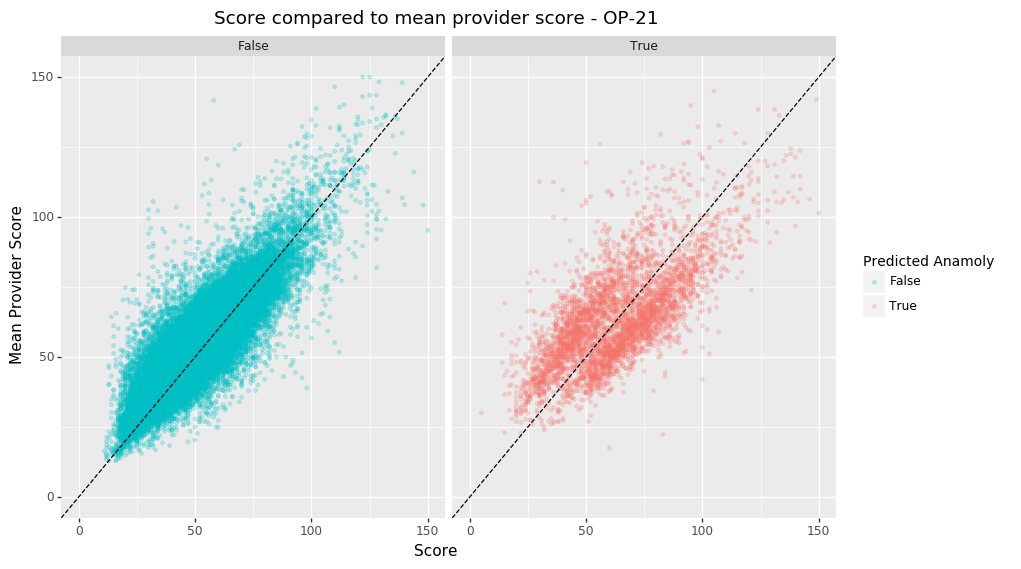

<ggplot: (8749106311465)>

In [29]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score - OP-21")
 + geom_point(size = 1, alpha = 0.2)
 + xlim(0,150)
 + ylim(0,150)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

### Score compared to mean provider score (outliers only)

/opt/conda/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 16 rows containing missing values.


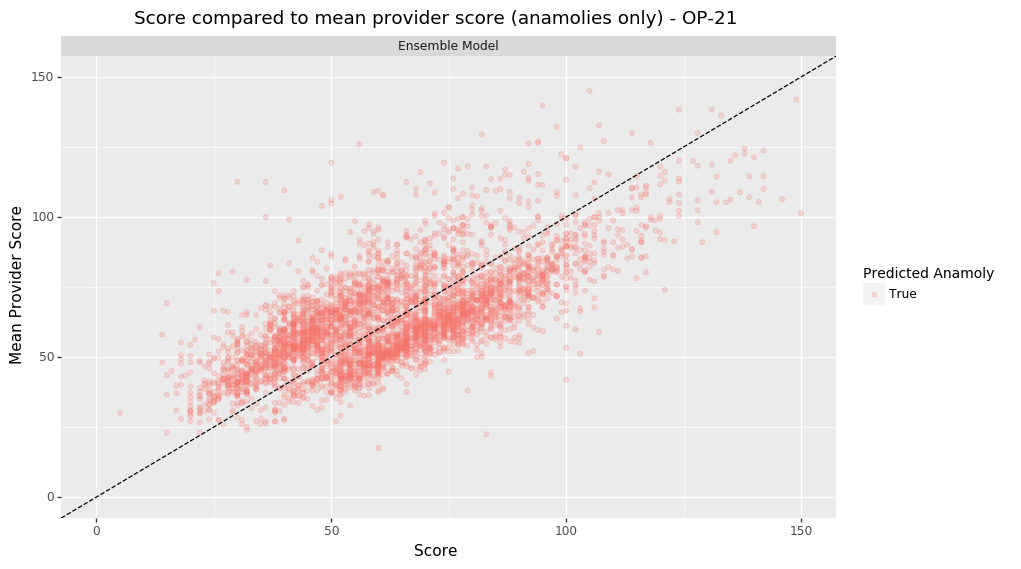

<ggplot: (8749105645505)>

In [30]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model" and outlier == True'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only) - OP-21")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,150)
 + ylim(0,150)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

### Predicted outlier distribution by quarter

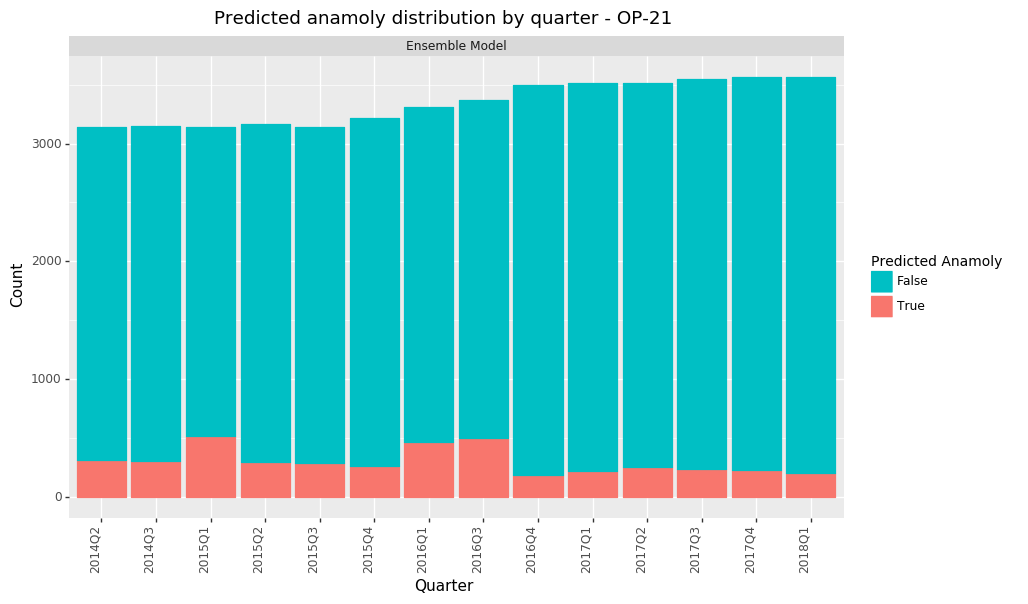

<ggplot: (8749104529781)>

In [31]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter - OP-21")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

In [32]:
comparison_df.loc[comparison_df['y_quarter'] == '2016Q1']

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
7,64.0,2016Q1,100001,74.571429,-6.0,-10.571429,False,67.920387,XGBoost Regression
22,56.0,2016Q1,100002,53.571429,0.0,2.428571,False,55.196407,XGBoost Regression
37,66.0,2016Q1,100006,68.857143,3.0,-2.857143,False,62.258450,XGBoost Regression
52,79.0,2016Q1,100007,82.285714,-1.0,-3.285714,False,77.804817,XGBoost Regression
67,43.0,2016Q1,100008,37.142857,2.0,5.857143,False,41.469826,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
50591,56.0,2016Q1,90004,70.714286,-8.0,-14.714286,False,62.805935,Ensemble Model
50606,50.0,2016Q1,90005,45.714286,6.0,4.285714,False,43.916733,Ensemble Model
50620,102.0,2016Q1,90006,132.666667,0.0,-30.666667,False,100.444557,Ensemble Model
50635,84.0,2016Q1,90008,113.571429,-43.0,-29.571429,True,109.541077,Ensemble Model
